In [1]:
%%capture capt
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.utils import get_laplacian

from mewisPool_layer import MLP, MEWISPool

# Define Models

In [3]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, device):
        super(Net, self).__init__()

        self.gc1 = GINConv(MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.pool1 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc2 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.pool2 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc3 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.gc1(x, edge_index))

        x_pooled, edge_index_pooled, batch_pooled, loss1 = self.pool1(x, edge_index, batch)

        x_pooled = F.relu(self.gc2(x_pooled, edge_index_pooled))

        x_pooled, edge_index_pooled, batch_pooled, loss2 = self.pool2(x_pooled, edge_index_pooled,
                                                                                batch_pooled)

        x_pooled = self.gc3(x_pooled, edge_index_pooled)
        # readout = global_mean_pool(x_pooled, batch_pooled)
        readout = torch.cat([x_pooled[batch_pooled == i].mean(0).unsqueeze(0) for i in torch.unique(batch_pooled)],
                    dim=0)

        out = self.fc1(readout)
        out = torch.relu(out)
        out = self.fc2(out)

        return out, loss1 + loss2

In [4]:
class Net_complex(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, device):
        super(Net_complex, self).__init__()

        self.gc1 = GINConv(MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.gc2 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.pool1 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc3 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.gc4 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.pool2 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc5 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=num_classes)

    def forward(self, x, edge_index, batch):
        x = self.gc1(x, edge_index)
        x = torch.relu(x)

        x = self.gc2(x, edge_index)
        x = torch.relu(x)

        x_pooled1, edge_index_pooled1, batch_pooled1, loss1 = self.pool1(x, edge_index, batch)

        x_pooled1 = self.gc3(x_pooled1, edge_index_pooled1)
        x_pooled1 = torch.relu(x_pooled1)

        x_pooled1 = self.gc4(x_pooled1, edge_index_pooled1)
        x_pooled1 = torch.relu(x_pooled1)

        x_pooled2, edge_index_pooled2, batch_pooled2, loss2 = self.pool2(x_pooled1, edge_index_pooled1,
                                                                                 batch_pooled1)

        x_pooled2 = self.gc5(x_pooled2, edge_index_pooled2)
        x_pooled2 = torch.relu(x_pooled2)

        readout = torch.cat([x_pooled2[batch_pooled2 == i].mean(0).unsqueeze(0) for i in torch.unique(batch_pooled2)],
                            dim=0)

        out = self.fc1(readout)
        out = torch.relu(out)
        out = self.fc2(out)

        return out, loss1 + loss2

# Apply on MUTAG

### Load data

In [5]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [6]:
torch.manual_seed(42)

path = 'data'
dataset = TUDataset(path, name='MUTAG', use_node_attr=True, use_edge_attr=True).shuffle()

input_dim = dataset.num_features
num_classes = dataset.num_classes

In [7]:
def get_dataloaders(BATCH_SIZE=20, VAL_PCT=0.1, TEST_PCT=0.1):
    BATCH_SIZE = 20
    VAL_PCT = 0.1
    TEST_PCT = 0.1
    
    n_train = int(len(dataset) * (1 - VAL_PCT - TEST_PCT))
    n_val = int(len(dataset) * VAL_PCT)
    
    train_dataset = dataset[:n_train]
    val_dataset = dataset[n_train: n_train+n_val]
    test_dataset = dataset[n_train+n_val:]
    
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    return train_loader, val_loader, test_loader

In [8]:
BATCH_SIZE = 20
VAL_PCT = 0.15
TEST_PCT = 0.1

train_loader, val_loader, test_loader = get_dataloaders(BATCH_SIZE=BATCH_SIZE, VAL_PCT=VAL_PCT, TEST_PCT=TEST_PCT)
print(f'{len(train_loader.dataset)} training samples, {len(val_loader.dataset)} validation samples, '
      f'{len(test_loader.dataset)} test samples.')

150 training samples, 18 validation samples, 20 test samples.


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Load model architectures

In [10]:
hidden_dim = 32
nb_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-5
scheduler_patience = 10
scheduler_factor = 1e-1
patience = 50

In [11]:
def create_model(model_architecture, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
        learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor, verbose_scheduler=True):

    model = model_architecture(input_dim=input_dim, 
                hidden_dim=hidden_dim, num_classes=num_classes, device=device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                           patience=scheduler_patience,
                                                           factor=scheduler_factor,
                                                           verbose=verbose_scheduler)
    criterion = torch.nn.CrossEntropyLoss()
    return model, optimizer, scheduler, criterion

### Train models

In [12]:
def validate(model, val_loader, criterion, device):
    val_loss = 0.
    val_corrects = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            data = data.to(device)
            out, loss_pool = model(data.x, data.edge_index, data.batch)
            loss_classification = criterion(out, data.y)
            loss = loss_classification + 0.01 * loss_pool
            val_loss += loss.item()
            val_corrects += (F.softmax(out, dim=1).argmax(dim=1) == data.y).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_corrects / len(val_loader.dataset)
    return val_loss, val_acc

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    train_loss = 0.
    train_corrects = 0
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out, loss_pool = model(data.x, data.edge_index, data.batch)
        loss_classification = criterion(out, data.y)
        loss = loss_classification + 0.01 * loss_pool

        loss.backward()
        train_loss += loss.item()
        train_corrects += (F.softmax(out, dim=1).argmax(dim=1) == data.y).sum().item()
        optimizer.step()

    train_loss /= len(train_loader)
    train_acc = train_corrects / len(train_loader.dataset)
    scheduler.step(train_loss)
    return train_loss, train_acc

In [14]:
def train(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, nb_epochs, patience, device,
         print_every=None):

    best_val_loss = float('inf')
    best_test_acc = None
    counter = 0

    train_losses,  val_losses, test_losses = [], [], []
    train_accs, val_accs, test_accs = [], [], []

    if print_every is None:
        print_every = 1 if nb_epochs <= 20 else int(nb_epochs/20)

    for epoch in range(nb_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        if epoch % print_every == 0 or epoch == nb_epochs - 1:
            print(f"Epoch [{epoch}/{nb_epochs}], Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Test loss: {test_loss:.3f},"
                  f" Train acc: {train_acc:.2f}, Val acc: {val_acc:.2f}, Test acc: {test_acc:.2f}")

        # Early-Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_test_acc = test_acc
            counter = 0
        else:
            counter += 1

        # Early stopping
        if counter > patience:
            print(f'======== Early stopping at Epoch {epoch} ========')
            if epoch % print_every != 0:
                    print(f"Epoch [{epoch}/{nb_epochs}], Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Test loss: {test_loss:.3f},"
                          f" Train acc: {train_acc:.2f}, Val acc: {val_acc:.2f}, Test acc: {test_acc:.2f}")
            break

    return train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc

In [15]:
model, optimizer, scheduler, criterion = create_model(Net)
model_5, optimizer_5, scheduler_5, criterion_5 = create_model(Net_complex)

In [16]:
train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, _ = train(
    model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, 
    nb_epochs, patience, device, print_every=1)

Epoch [0/200], Train loss: 3.607, Val loss: 3.467, Test loss: 3.737, Train acc: 0.70, Val acc: 0.50, Test acc: 0.60
Epoch [1/200], Train loss: 2.818, Val loss: 2.631, Test loss: 2.792, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [2/200], Train loss: 1.721, Val loss: 1.793, Test loss: 1.807, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [3/200], Train loss: 0.938, Val loss: 1.268, Test loss: 1.222, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [4/200], Train loss: 0.713, Val loss: 1.078, Test loss: 0.984, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [5/200], Train loss: 0.681, Val loss: 0.954, Test loss: 0.859, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [6/200], Train loss: 0.629, Val loss: 0.854, Test loss: 0.753, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [7/200], Train loss: 0.604, Val loss: 0.783, Test loss: 0.661, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [8/200], Train loss: 0.616, Val loss: 0.700, Test loss: 0.632, Tra

In [17]:
train_losses_5, val_losses_5, test_losses_5, train_accs_5, val_accs_5, test_accs_5, _ = train(
    model_5, criterion_5, optimizer_5, scheduler_5, train_loader, val_loader, test_loader, 
    nb_epochs, patience, device, print_every=1)

Epoch [0/200], Train loss: 3.640, Val loss: 3.511, Test loss: 3.784, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [1/200], Train loss: 2.806, Val loss: 2.544, Test loss: 2.679, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [2/200], Train loss: 1.552, Val loss: 1.672, Test loss: 1.696, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [3/200], Train loss: 0.803, Val loss: 1.502, Test loss: 1.505, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [4/200], Train loss: 0.700, Val loss: 1.194, Test loss: 1.091, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [5/200], Train loss: 0.675, Val loss: 0.961, Test loss: 0.902, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [6/200], Train loss: 0.673, Val loss: 0.868, Test loss: 0.832, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [7/200], Train loss: 0.625, Val loss: 0.896, Test loss: 0.806, Train acc: 0.69, Val acc: 0.50, Test acc: 0.60
Epoch [8/200], Train loss: 0.630, Val loss: 0.847, Test loss: 0.797, Tra

### Plot metrics

In [18]:
def plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, suptitle=''): 
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].plot(test_losses, label='Test Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()
    axs[0].grid('on')
    
    # Plot accuracies
    axs[1].plot(train_accs, label='Train Acc')
    axs[1].plot(val_accs, label='Val Acc')
    axs[1].plot(test_accs, label='Test Acc')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    axs[1].grid('on')
    
    plt.tight_layout()
    plt.suptitle(suptitle)
    
    plt.show()

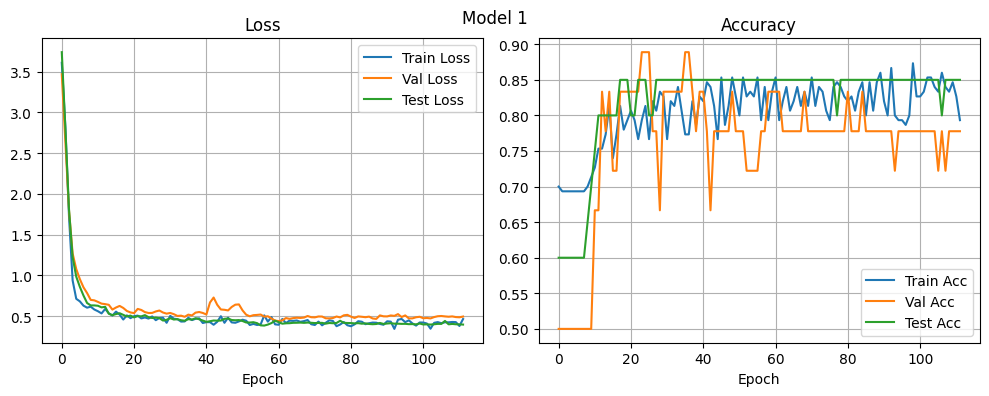

In [19]:
plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, suptitle='Model 1')

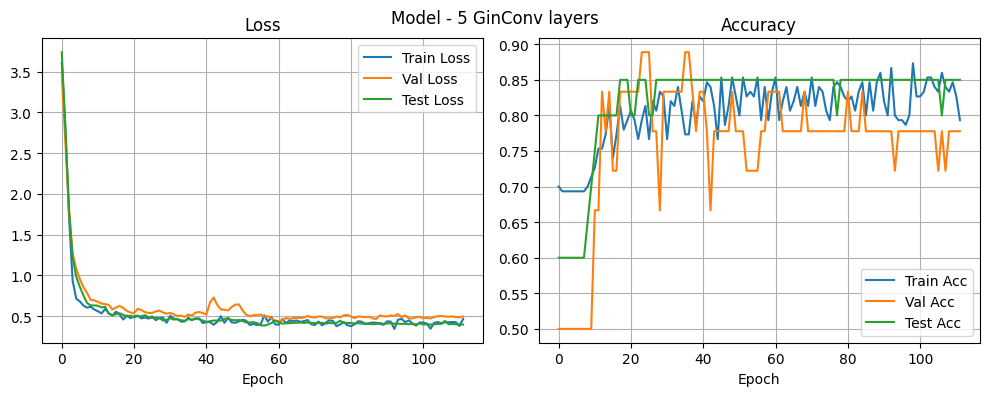

In [20]:
plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, suptitle='Model - 5 GinConv layers')

### 10-fold validation

In [21]:
BATCH_SIZE = 20
VAL_PCT = 0.15
TEST_PCT = 0.1

hidden_dim = 32
nb_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-5
scheduler_patience = 10
scheduler_factor = 1e-1
patience = 50

In [22]:
def run_all(model_architecture, batch_size=BATCH_SIZE, val_pct=VAL_PCT, test_pct=TEST_PCT, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
                                learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor,
                                nb_epochs=nb_epochs, patience=patience):

    train_loader, val_loader, test_loader = get_dataloaders(BATCH_SIZE=batch_size, VAL_PCT=val_pct, TEST_PCT=test_pct)
    model, optimizer, scheduler, criterion = create_model(model_architecture, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
                                learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor, verbose_scheduler=False)
    train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc = train(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, 
                        nb_epochs, patience, device, print_every=nb_epochs)
    return train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc

In [23]:
def run_10_fold(model_architecture, batch_size=BATCH_SIZE, val_pct=VAL_PCT, test_pct=TEST_PCT, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
                                learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor,
                                nb_epochs=nb_epochs, patience=patience, plot_=None):

    results = {}
    index_best_test_acc_all_folds = -1
    best_test_acc_all_folds = 0
    for i in range(10):
        print(f'Running fold {i}')
        train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc = run_all(model_architecture, batch_size=batch_size, val_pct=val_pct, test_pct=test_pct, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
                                learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor,
                                nb_epochs=nb_epochs, patience=patience)
        results[i] = train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc
        if best_test_acc_all_folds < best_test_acc:
            best_test_acc_all_folds = best_test_acc
            index_best_test_acc_all_folds = i

    if plot_ is not None:
        train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, _ = results[index_best_test_acc_all_folds]
        plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, suptitle=plot_)
    return results

Running fold 0
Epoch [0/200], Train loss: 3.336, Val loss: 3.172, Test loss: 3.446, Train acc: 0.45, Val acc: 0.50, Test acc: 0.40
======== Early stopping at Epoch 75 ========
Epoch [75/200], Train loss: 0.409, Val loss: 0.659, Test loss: 0.367, Train acc: 0.83, Val acc: 0.61, Test acc: 0.85
Running fold 1
Epoch [0/200], Train loss: 4.165, Val loss: 3.760, Test loss: 4.065, Train acc: 0.40, Val acc: 0.50, Test acc: 0.40
======== Early stopping at Epoch 98 ========
Epoch [98/200], Train loss: 0.463, Val loss: 0.450, Test loss: 0.416, Train acc: 0.81, Val acc: 0.89, Test acc: 0.85
Running fold 2
Epoch [0/200], Train loss: 3.887, Val loss: 3.702, Test loss: 4.060, Train acc: 0.39, Val acc: 0.50, Test acc: 0.40
======== Early stopping at Epoch 83 ========
Epoch [83/200], Train loss: 0.410, Val loss: 0.548, Test loss: 0.398, Train acc: 0.85, Val acc: 0.83, Test acc: 0.85
Running fold 3
Epoch [0/200], Train loss: 4.126, Val loss: 3.683, Test loss: 4.004, Train acc: 0.47, Val acc: 0.72, Test 

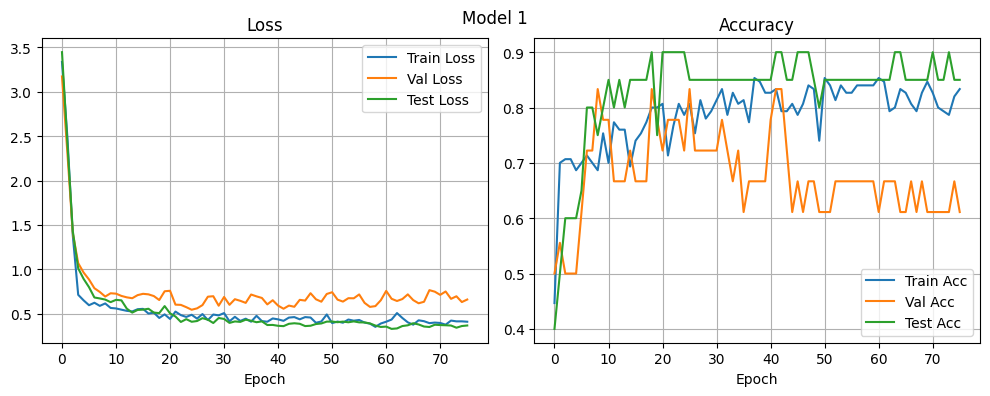

In [26]:
results = run_10_fold(Net, plot_='Model 1')

Running fold 0
Epoch [0/200], Train loss: 4.192, Val loss: 3.840, Test loss: 4.173, Train acc: 0.63, Val acc: 0.50, Test acc: 0.60
======== Early stopping at Epoch 101 ========
Epoch [101/200], Train loss: 0.451, Val loss: 0.528, Test loss: 0.473, Train acc: 0.77, Val acc: 0.83, Test acc: 0.75
Running fold 1
Epoch [0/200], Train loss: 3.778, Val loss: 3.597, Test loss: 3.945, Train acc: 0.57, Val acc: 0.50, Test acc: 0.60
======== Early stopping at Epoch 79 ========
Epoch [79/200], Train loss: 0.447, Val loss: 0.504, Test loss: 0.436, Train acc: 0.77, Val acc: 0.83, Test acc: 0.85
Running fold 2
Epoch [0/200], Train loss: 4.300, Val loss: 3.968, Test loss: 4.354, Train acc: 0.58, Val acc: 0.50, Test acc: 0.40
======== Early stopping at Epoch 85 ========
Epoch [85/200], Train loss: 0.445, Val loss: 0.535, Test loss: 0.517, Train acc: 0.78, Val acc: 0.72, Test acc: 0.85
Running fold 3
Epoch [0/200], Train loss: 3.775, Val loss: 3.638, Test loss: 3.999, Train acc: 0.32, Val acc: 0.50, Tes

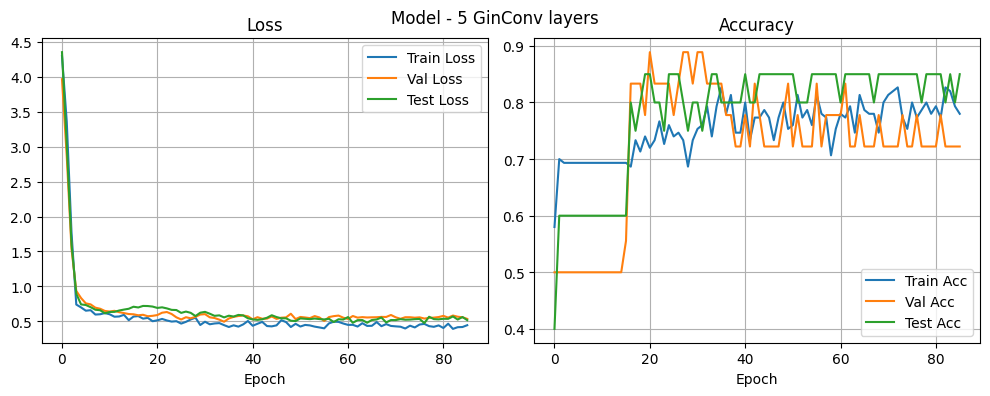

In [28]:
results_5 = run_10_fold(Net_complex, plot_='Model - 5 GinConv layers')